In [1]:
import pandas as pd
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchmetrics import Accuracy
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(42) # set manual seed

#### Dataset info

- https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html
- Can also be found on kaggle: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

#### Load data and view an image

In [3]:
# load data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

In [4]:
# dataset contains the pictures as <class 'PIL.Image.Image'>
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [5]:
# contains the image and a number as a tuple
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [6]:
# split up tuple to see image
train_image_zero, train_target_zero = train_dataset[0]

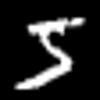

In [7]:
# resize image because original is small
resized_image = train_image_zero.resize((100, 100))

#train_image_zero
resized_image

In [8]:
# see what's in test dataset
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

#### Transform images to tensors
- use torchvision.transforms to convert images to tensors & transforms.Compose allows you to stack multiple transformations at once
    - link: https://pytorch.org/vision/0.9/transforms.html 
- if you try to apply ToTensor() on the train_dataset you will run into:
    - you get an <AttributeError: 'MNIST' object has no attribute 'torchvision'>
    - <TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given> because tuples

In [33]:
# define transformations
transformations = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))])  # using 0.5, 0.5, on many datasets will rearrange them to [-1, +1]

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformations)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformations)

In [34]:
# transform to dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [35]:
train_loader

In [49]:
data_iter = iter(train_loader)  # Create an iterator
images, labels = next(data_iter)  # Get the next batch
images.shape
#labels.shape

torch.Size([64, 1, 28, 28])

##### Helpful link: 
- https://www.cs.toronto.edu/~lczhang/321/tut/tut04.html

In [62]:
class MultiClassificationModel(nn.Module):
  def __init__(self):
    super(MultiClassificationModel, self).__init__()
    self.lin1 = nn.Linear(784, 128)  #784 input features due to 28x28 pixel image
    self.dp1 = nn.Dropout(p=0.5)
    self.lin2 = nn.Linear(128, 10)
    self.act = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.view(x.size(0), -1)  # Flatten from [batch_size, 1, 28, 28] to [batch_size, 784]
    x = self.dp1(F.relu(self.lin1(x)))
    x = self.act(self.lin2(x))
    return x
  
model = MultiClassificationModel()

In [64]:
# loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0
    model.train()
    for images, labels in iter(train_loader):
        output = model(images) # model.forward()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() # keep track of overall loss rate
    avg_loss = running_loss/len(train_loader)
    #if not(epoch+1) % 10:
    print(f"Average Loss {avg_loss}, Epoch: {epoch+1}")

Average Loss 1.5724898040421735, Epoch: 1
Average Loss 1.565006990422572, Epoch: 2


In [66]:
acc = Accuracy(task='multiclass', num_classes=10)
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1) 
        acc.update(predicted, labels)

print(f"Accuracy: {acc.compute().item()}")

Accuracy: 0.9305999875068665
